In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import matplotlib.pyplot as plt

/home/aviator98/anaconda3/envs/python3.11_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/aviator98/anaconda3/envs/python3.11_env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
import torch
from torchvision import datasets, transforms

# Define the transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Calculate the lengths for training and validation sets
train_size = int(0.7 * len(full_train_dataset))
val_size = int(0.1 * len(full_train_dataset))
test_size = len(full_train_dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, _ = torch.utils.data.random_split(full_train_dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print(len(train_loader), len(val_loader), len(test_loader)) 

1313 188 313


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from scipy.ndimage import gaussian_filter, map_coordinates

# Elastic Deformation for Data Augmentation
def elastic_deformation(image, sigma=4, alpha=20):
    shape = image.shape
    dx = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma) * alpha
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), indexing='ij')
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
    return map_coordinates(image, indices, order=1).reshape(shape)

# Encoder Network
class Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, latent_dim),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.conv(x)

# Decoder Network
class Decoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Decoder, self).__init__()
        self.deconv = nn.Sequential(
            nn.Linear(latent_dim, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, z):
        return self.deconv(z)

# Prototype Layer
class PrototypeLayer(nn.Module):
    def __init__(self, num_prototypes=20, latent_dim=128):
        super(PrototypeLayer, self).__init__()
        self.prototypes = nn.Parameter(torch.randn(num_prototypes, latent_dim))
    
    def forward(self, features):
        distances = torch.cdist(features, self.prototypes)  # Compute distances to prototypes
        return distances

# Full Model
class PrototypeNetwork(nn.Module):
    def __init__(self, latent_dim=128, num_prototypes=20, num_classes=10):
        super(PrototypeNetwork, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.prototype_layer = PrototypeLayer(num_prototypes, latent_dim)
        self.classifier = nn.Linear(num_prototypes, num_classes)
        self.decoder = Decoder(latent_dim)
    
    def forward(self, x):
        features = self.encoder(x)
        distances = self.prototype_layer(features)
        classification = self.classifier(-distances)  # Negative distance for classification
        reconstruction = self.decoder(features)
        return classification, reconstruction, distances

# Loss Functions
def compute_losses(model, x, y, criterion, alpha=0.1, beta=0.1):
    classification, reconstruction, distances = model(x)
    
    # Classification loss
    class_loss = criterion(classification, y)
    
    # Reconstruction loss
    recon_loss = F.mse_loss(reconstruction, x)
    
    # Interpretability Losses
    R1 = distances.min(dim=1)[0].mean()
    R2 = distances.min(dim=0)[0].mean()
    interpretability_loss = alpha * R1 + beta * R2
    
    total_loss = class_loss + recon_loss + interpretability_loss
    return total_loss, class_loss, recon_loss, R1, R2

# Training Loop
def train_model(model, train_loader, epochs=10, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            loss, _, _, _, _ = compute_losses(model, images, labels, criterion)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")
        train_losses.append(total_loss/len(train_loader))
    # plot the training loss
    plt.plot(train_losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    
    return model

# Prototype Contributions
def compute_prototype_contributions(model, data_loader, num_classes=10):
    contributions = torch.zeros(model.prototype_layer.prototypes.shape[0], num_classes)
    
    with torch.no_grad():
        for images, labels in data_loader:
            _, _, distances = model(images)
            contributions.scatter_add_(1, labels.unsqueeze(1), -distances)
    
    contributions /= torch.sum(contributions, dim=1, keepdim=True)  # Normalize
    print("Prototype Contributions to Each Class:")
    print(contributions.numpy())

/home/aviator98/anaconda3/envs/python3.11_env/lib/python3.11/site-packages/torch/autograd/graph.py:825: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Loss: 2.9451478108684253
Epoch 2, Loss: 1.5194522199608946
Epoch 3, Loss: 0.9633202098383762
Epoch 4, Loss: 0.7771611004863545
Epoch 5, Loss: 0.7272894672101813
Epoch 6, Loss: 0.6938311133054224
Epoch 7, Loss: 0.6688357120420946
Epoch 8, Loss: 0.6476135962534205
Epoch 9, Loss: 0.628308078848671
Epoch 10, Loss: 0.6123279741222588


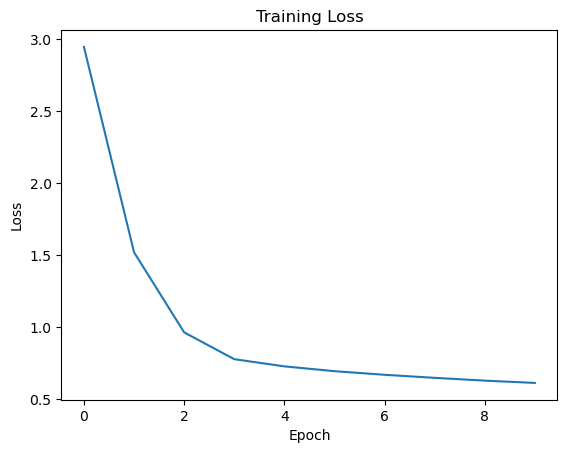

In [5]:
model = PrototypeNetwork(num_prototypes=18)

model = train_model(model, train_loader, epochs=10)

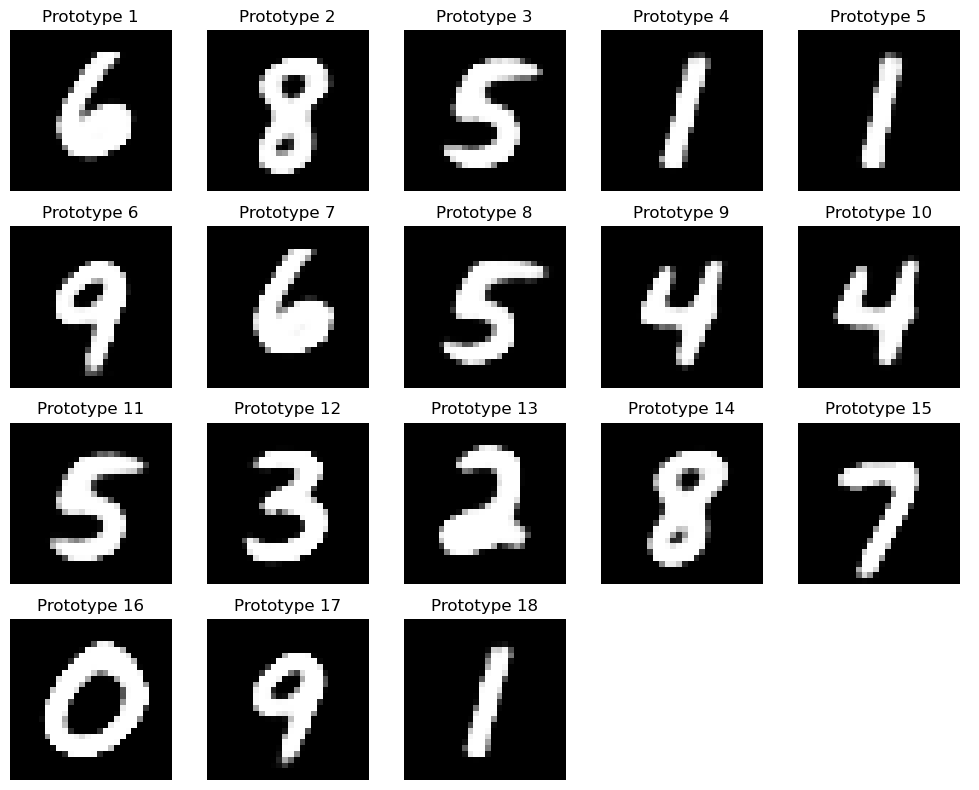

In [6]:
def visualize_prototypes(model, device, num_cols=5):
    model.eval()
    
    # Get the learned prototypes
    prototypes = model.prototype_layer.prototypes.detach().cpu()  # Shape: (num_prototypes, feature_dim)
    
    # Pass through the decoder to reconstruct images
    with torch.no_grad():
        reconstructed_prototypes = model.decoder(prototypes.to(device))  # Shape: (num_prototypes, 1, 28, 28)
    
    # Convert to CPU for visualization
    reconstructed_prototypes = reconstructed_prototypes.cpu().numpy()
    
    num_prototypes = reconstructed_prototypes.shape[0]
    num_rows = (num_prototypes // num_cols) + int(num_prototypes % num_cols != 0)
    
    # Plot prototypes
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    axes = axes.flatten()
    
    for i in range(num_prototypes):
        axes[i].imshow(reconstructed_prototypes[i][0], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Prototype {i+1}')
    
    for j in range(i + 1, len(axes)):  # Hide unused subplots
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
visualize_prototypes(model, device)


In [7]:
import numpy as np
import torch

def get_samples_by_label(test_loader, num_classes=10):
    """
    Loops through the test_loader and extracts one sample per label.
    
    Args:
        test_loader (torch.utils.data.DataLoader): The test dataset loader.
        num_classes (int): Number of unique labels to collect samples for.

    Returns:
        np.ndarray: An array of shape (num_classes, 28, 28) containing one sample per class.
        list: List of corresponding labels.
    """
    samples = [None] * num_classes  # Placeholder list for each label
    labels_found = set()

    for images, labels in test_loader:
        for i in range(len(labels)):
            label = labels[i].item()
            if label not in labels_found:  # Store only if not already collected
                samples[label] = images[i].squeeze().numpy()  # Convert to (28,28)
                labels_found.add(label)

            if len(labels_found) == num_classes:  # Stop if all labels are collected
                break
        
        if len(labels_found) == num_classes:
            break

    return np.array(samples), list(labels_found)

# Get one sample per label
samples_np, labels_list = get_samples_by_label(test_loader)

print("Samples shape:", samples_np.shape)  # Expected: (10, 28, 28)
print("Labels:", labels_list)  # Expected: [0, 1, 2, ..., 9]


Samples shape: (10, 28, 28)
Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


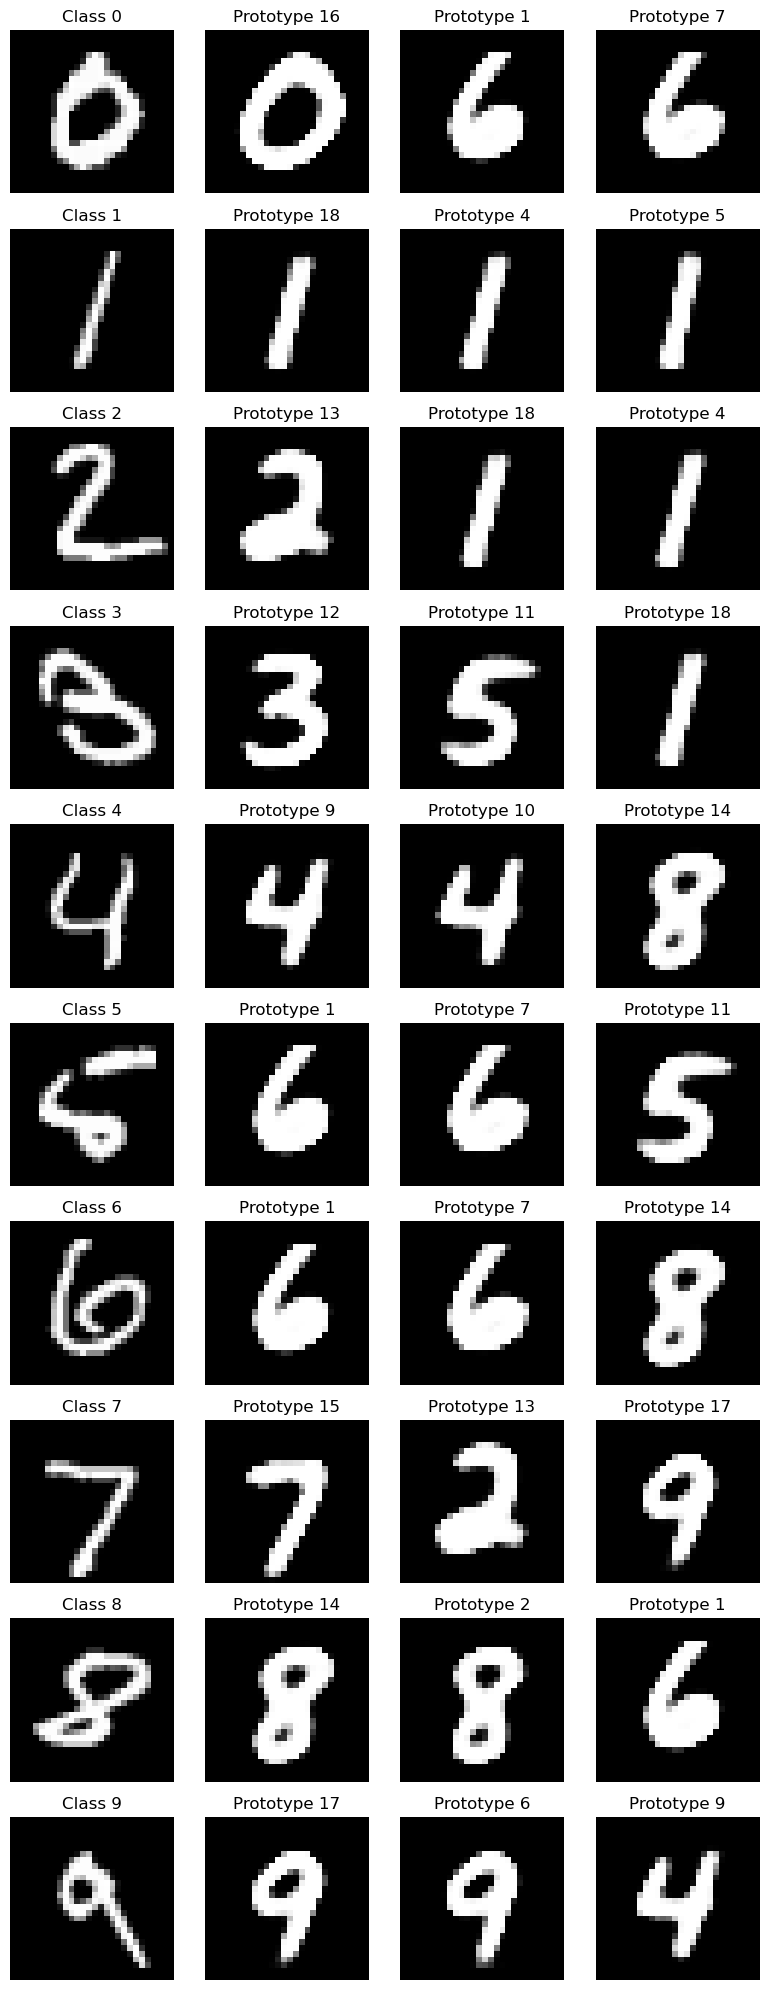

In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random

# Function to get one sample per class
def get_one_sample_per_class(test_loader, num_classes=10):
    class_samples = {}
    for images, labels in test_loader:
        for i in range(len(labels)):
            label = labels[i].item()
            if label not in class_samples:  # Store only one sample per class
                class_samples[label] = images[i].to(device)
            if len(class_samples) == num_classes:
                return class_samples
    return class_samples

# Function to visualize influential prototypes for multiple classes
def visualize_prototypes_for_each_class(model, class_samples, device, top_k=3):
    model.eval()
    fig, axes = plt.subplots(len(class_samples), top_k + 1, figsize=(2 * (top_k + 1), 2 * len(class_samples)))

    for row_idx, (label, sample_image) in enumerate(sorted(class_samples.items())):
        sample_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension

        # Extract features using the encoder
        with torch.no_grad():
            sample_features = model.encoder(sample_image)

        # Compute distances to prototypes
        prototype_vectors = model.prototype_layer.prototypes.to(device)  
        distances = torch.norm(sample_features - prototype_vectors, dim=1)  

        # Get the indices of the top_k closest prototypes
        top_k_indices = torch.argsort(distances)[:top_k]  

        # Decode the top_k prototypes to image space
        with torch.no_grad():
            influential_prototypes = model.decoder(prototype_vectors[top_k_indices])  

        # Move to CPU for visualization
        influential_prototypes = influential_prototypes.cpu().numpy()
        sample_image = sample_image.cpu().squeeze().numpy()

        # Plot sample image
        axes[row_idx, 0].imshow(sample_image, cmap='gray')
        axes[row_idx, 0].set_title(f"Class {label}")
        axes[row_idx, 0].axis('off')

        # Plot influential prototypes
        for i, idx in enumerate(top_k_indices):
            axes[row_idx, i + 1].imshow(influential_prototypes[i][0], cmap='gray')
            axes[row_idx, i + 1].set_title(f"Prototype {idx.item() + 1}")
            axes[row_idx, i + 1].axis('off')

    plt.tight_layout()
    plt.show()

# Load device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

# Fetch one test sample per class
class_samples = get_one_sample_per_class(test_loader)

# Visualize prototypes for each class
visualize_prototypes_for_each_class(model, class_samples, device)
